In [17]:
import pandas as pd
import os
import numpy as np
import scipy
from scipy.special import expit
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score
import pyspark
from pathlib import Path
import csv
import datetime
import statistics
import xgboost as xgb
from xgboost import XGBClassifier
from shiny import App, ui, render, reactive, run_app
from shinywidgets import output_widget, render_widget
import ipyleaflet as ipyl

In [18]:
# Preprocessing

In [22]:
patient_folder = Path(r"../Datasets/glucdict-1/Glucdict Dataset")
nhanes_folder = Path(r"E:/OneDrive/Documents/Courses/Intro_Data_Science/")

## Load all the sensor data for each user first since that is more complicated.
#### We won't use the phone activity files since not every patient has it

In [23]:
# after doing some data exploration, it was discovered that one of the sensor files has bad rows at the beginning 
# which just say plugged out and plugged in but an improper number of columns

def clean_first_two_lines_if_malformed(file_path, expected_columns=5):
    """
    Checks the first two lines of a file and removes them if they have fewer than expected_columns.
    Overwrites the file in place with corrected content.
    """
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()

        # Check how many columns each line has
        cleaned_lines = []
        for i, line in enumerate(lines):
            if i < 2:
                if len(line.strip().split(',')) < expected_columns:
                    continue  # skip malformed line
            cleaned_lines.append(line)

        # Write cleaned lines back to the same file
        with open(file_path, 'w', encoding='utf-8') as f:
            f.writelines(cleaned_lines)

        print(f"[CLEANED] {file_path}: Removed malformed lines.")
    except Exception as e:
        print(f"[ERROR] Could not clean {file_path}: {e}")


In [24]:
clean_first_two_lines_if_malformed(os.path.join(patient_folder,r'User10\Watch\10_SensorReader.csv'))

[CLEANED] ..\Datasets\glucdict-1\Glucdict Dataset\User10\Watch\10_SensorReader.csv: Removed malformed lines.


In [25]:
sensor_map = {
    1:  "ACCELEROMETER",
    2:  "MAGNETIC_FIELD",
    4:  "GYROSCOPE",
    9:  "GRAVITY",
    10: "LINEAR_ACCELERATION",
    11: "ROTATION_VECTOR",
    18: "STEP_DETECTOR",
    19: "STEP_COUNTER",
    21: "HEART_RATE",
    99: "EARTH_ACC"
}


def load_user_sensor_data(user_id, patient_folder):
    """
    Robustly loads and concatenates all sensor data CSV files containing 'SensorReader' 
    from a user's folder (including Phone/Sensors and Watch), adds a user_id column.
    Filters out malformed lines and handles large files line by line.
    """
    user_path = os.path.join(patient_folder, user_id)
    sensor_dfs = []

    for root, _, files in os.walk(user_path):
        for file in files:
            if "SensorReader" in file and file.endswith(".csv"):
                file_path = os.path.join(root, file)
                try:
                    df = pd.read_csv(
                        file_path,
                        header=None,
                        engine='python',
                        on_bad_lines='skip',
                        dtype=str
                    )
                    if df.shape[1] == 5:
                        df.columns = ['sensor', 'timestamp', 'x', 'y', 'z']
                        df['sensor'] = pd.to_numeric(df['sensor'], errors='coerce').map(sensor_map).fillna(df['sensor'])
                        df['user_id'] = user_id
                        df['timestamp'] = pd.to_datetime(pd.to_numeric(df['timestamp'], errors='coerce'), unit='ms', errors='coerce')
                        for col in ['x', 'y', 'z']:
                            df[col] = pd.to_numeric(df[col], errors='coerce')
                        sensor_dfs.append(df)
                except Exception as e:
                    print(f"[ERROR] Failed to process {file_path}: {e}")

    if not sensor_dfs:
        return pd.DataFrame()

    return pd.concat(sensor_dfs, ignore_index=True)

In [26]:
# for example:
test1 = load_user_sensor_data('User1', patient_folder)
test1.head()

,sensor,timestamp,x,y,z,user_id
0,ACCELEROMETER,2021-11-29 06:32:26.110,1.626,1.803,9.638,User1
1,GYROSCOPE,2021-11-29 06:32:26.158,-0.019,0.013,-0.020,User1
2,MAGNETIC_FIELD,2021-11-29 06:32:26.129,169.326,-141.762,-65.010,User1
3,GYROSCOPE,2021-11-29 06:32:26.311,-0.012,0.001,0.017,User1
4,MAGNETIC_FIELD,2021-11-29 06:32:26.225,213.658,-261.143,-37.326,User1


In [27]:
def extract_sensor_features(df, accel_movement_threshold=1.2):
    """
    Extracts per-user features from 3-axis sensor data, heart rate, and step detector.
    Includes:
    - Mean/std/min/max/median magnitude for each 3-axis sensor
    - Percent time moving from accelerometer
    - Average daily steps from STEP_DETECTOR
    - Resting HR, mean HR, and time in personalized HR zones from HEART_RATE

    Parameters:
        df: DataFrame with columns ['sensor', 'timestamp', 'x', 'y', 'z', 'user_id']
        accel_movement_threshold: float, magnitude threshold to count as 'moving'
    Returns:
        DataFrame with one row per user, features per sensor
    """
    feature_list = []

    # Ensure x, y, z are numeric
    for col in ['x', 'y', 'z']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    for sensor in df['sensor'].unique():
        sensor_str = str(sensor).strip().upper()
        if sensor_str not in ['ACCELEROMETER', 'GYROSCOPE', 'MAGNETIC_FIELD', 'GRAVITY']:
            continue

        sensor_df = df[df['sensor'].str.strip().str.upper() == sensor_str].copy()
        sensor_df['magnitude'] = np.sqrt(sensor_df['x']**2 + sensor_df['y']**2 + sensor_df['z']**2)

        grouped = sensor_df.groupby('user_id')['magnitude']
        features = grouped.agg(['mean', 'std', 'min', 'max', 'median'])
        features.columns = [f"{sensor_str.lower()}_{col}" for col in features.columns]

        if sensor_str == 'ACCELEROMETER':
            move_counts = sensor_df.groupby('user_id').apply(
                lambda g: (g['magnitude'] > accel_movement_threshold).sum()
            )
            total_counts = sensor_df.groupby('user_id').size()
            percent_moving = (move_counts / total_counts).fillna(0)
            features[f"{sensor_str.lower()}_percent_time_moving"] = percent_moving

        feature_list.append(features)
    if not feature_list:
        feature_df =  pd.DataFrame({'user_id': df['user_id'].unique()})
    else:
        feature_df = pd.concat(feature_list, axis=1).reset_index()

    if any(str(s).strip().upper() == 'STEP_DETECTOR' for s in df['sensor'].unique()):
        step_df = df[df['sensor'] == 'STEP_DETECTOR'].copy()
        step_df['timestamp'] = pd.to_datetime(step_df['timestamp'])
        step_df['date'] = step_df['timestamp'].dt.date

        daily_steps = step_df.groupby(['user_id', 'date']).size().reset_index(name='steps')
        avg_daily_steps = daily_steps.groupby('user_id')['steps'].mean().rename('avg_daily_steps')
        feature_df = feature_df.merge(avg_daily_steps.reset_index(), on='user_id', how='left')

    if any(str(s).strip().upper() == 'HEART_RATE' for s in df['sensor'].unique()):
        hr_df = df[df['sensor'] == 'HEART_RATE'].copy()
        hr_df = hr_df.rename(columns={'x': 'bpm'})
        hr_df['bpm'] = pd.to_numeric(hr_df['bpm'], errors='coerce')
        hr_df = hr_df[(hr_df['bpm'] >= 30) & (hr_df['bpm'] <= 220)]

        def personalized_zone_counts(group):
            resting = np.percentile(group['bpm'], 5)
            adj_ratio = group['bpm'] / resting
            total = len(group)
            return pd.Series({
                'hr_zone_rest': (adj_ratio < 1.0).sum() / total,
                'hr_zone_light': ((adj_ratio >= 1.0) & (adj_ratio < 1.25)).sum() / total,
                'hr_zone_moderate': ((adj_ratio >= 1.25) & (adj_ratio < 1.5)).sum() / total,
                'hr_zone_vigorous': ((adj_ratio >= 1.5) & (adj_ratio < 1.75)).sum() / total,
                'hr_zone_max': (adj_ratio >= 1.75).sum() / total,
                'resting_hr': resting
            })

        hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
        hr_summary = hr_df.groupby('user_id')['bpm'].mean().rename('mean_hr')
        hr_features = pd.concat([hr_zones, hr_summary], axis=1).reset_index()
        feature_df = feature_df.merge(hr_features, on='user_id', how='left')

    return feature_df

In [28]:
# as another example:
test2 = extract_sensor_features(test1)
test2.head()

C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)


,user_id,accelerometer_mean,accelerometer_std,accelerometer_min,accelerometer_max,accelerometer_median,accelerometer_percent_time_moving,gyroscope_mean,gyroscope_std,gyroscope_min,...,magnetic_field_max,magnetic_field_median,avg_daily_steps,hr_zone_rest,hr_zone_light,hr_zone_moderate,hr_zone_vigorous,hr_zone_max,resting_hr,mean_hr
0,User1,9.940485,1.456082,0.237895,133.557619,9.783041,0.999975,0.559347,1.021973,0.0,...,172631.880674,45.579995,11611.636364,0.049986,0.392288,0.368355,0.143496,0.045875,68.729,90.380149


In [29]:
test2.columns

Index(['user_id', 'accelerometer_mean', 'accelerometer_std',
       'accelerometer_min', 'accelerometer_max', 'accelerometer_median',
       'accelerometer_percent_time_moving', 'gyroscope_mean', 'gyroscope_std',
       'gyroscope_min', 'gyroscope_max', 'gyroscope_median',
       'magnetic_field_mean', 'magnetic_field_std', 'magnetic_field_min',
       'magnetic_field_max', 'magnetic_field_median', 'avg_daily_steps',
       'hr_zone_rest', 'hr_zone_light', 'hr_zone_moderate', 'hr_zone_vigorous',
       'hr_zone_max', 'resting_hr', 'mean_hr'],
      dtype='object')

## Next we get the glucose data

In [30]:
def load_user_glucose_data(user_id, patient_folder):
    """
    Loads glucose readings for a given user from their 'Glucose' subfolder.
    Returns a cleaned DataFrame with standardized columns and parsed timestamps.
    """

    user_path = os.path.join(patient_folder, user_id, "Glucose")
    
    if not os.path.exists(user_path):
        print(f"[WARN] Glucose folder not found for user: {user_id}")
        return pd.DataFrame()
    
    glucose_dfs = []

    for file in os.listdir(user_path):
        if file.endswith(".csv"):
            file_path = os.path.join(user_path, file)
            try:
                df = pd.read_csv(file_path)

                # Rename and parse
                df = df.rename(columns={
                    'Timestamp (YYYY-MM-DDThh:mm:ss)': 'timestamp',
                    'Glucose Value (mg/dL)': 'glucose_mg_dl'
                })
                df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
                df['user_id'] = user_id

                # Optional cleanup
                df = df[['timestamp', 'glucose_mg_dl', 'Transmitter Time (Long Integer)', 'Transmitter ID', 'user_id']]
                glucose_dfs.append(df)

            except Exception as e:
                print(f"[ERROR] Failed to read {file_path}: {e}")
    
    if not glucose_dfs:
        print(f"[INFO] No glucose CSVs found for user {user_id}")
        return pd.DataFrame()
    
    combined_glucose = pd.concat(glucose_dfs, ignore_index=True)
    return combined_glucose

In [31]:
def extract_glucose_features(glucose_df):
    """
    Extracts glucose features per user:
    - average glucose
    - IQR of glucose values
    - mean absolute rate of change (ROC)
    - number of hours per week with at least one hypo (<70) or hyper (>250) event
    - total time in minutes per day with glucose above 180
    """
    glucose_df = glucose_df.copy()
    glucose_df['timestamp'] = pd.to_datetime(glucose_df['timestamp'], errors='coerce')
    glucose_df['glucose_mg_dl'] = pd.to_numeric(glucose_df['glucose_mg_dl'], errors='coerce')
    glucose_df = glucose_df.dropna(subset=['timestamp', 'glucose_mg_dl'])
    glucose_df = glucose_df.sort_values(['user_id', 'timestamp'])

    features = []

    for user, group in glucose_df.groupby('user_id'):
        if group.shape[0] < 2:
            continue

        group = group.copy()
        group['delta_glucose'] = group['glucose_mg_dl'].diff()
        group['delta_time_min'] = group['timestamp'].diff().dt.total_seconds() / 60.0
        group['roc'] = (group['delta_glucose'] / group['delta_time_min']).abs()

        avg_glucose = group['glucose_mg_dl'].mean()
        iqr = group['glucose_mg_dl'].quantile(0.75) - group['glucose_mg_dl'].quantile(0.25)
        mean_roc = group['roc'].replace([np.inf, -np.inf], np.nan).dropna().mean()

        group['week'] = group['timestamp'].dt.isocalendar().week
        group['hour'] = group['timestamp'].dt.floor('H')

        hypo_hours = group[group['glucose_mg_dl'] < 70].drop_duplicates(subset=['week', 'hour'])
        hyper_hours = group[group['glucose_mg_dl'] > 250].drop_duplicates(subset=['week', 'hour'])

        hypo_counts = hypo_hours.groupby('week').size().mean()
        hyper_counts = hyper_hours.groupby('week').size().mean()

        group['date'] = group['timestamp'].dt.date
        group['delta_time_min'] = group['delta_time_min'].replace([np.inf, -np.inf], np.nan).fillna(0)
        high_glucose_minutes = group[group['glucose_mg_dl'] > 180].groupby('date')['delta_time_min'].sum()
        avg_daily_high_glucose_time = high_glucose_minutes.replace([np.inf, -np.inf], np.nan).dropna().mean()

        features.append({
            'user_id': user,
            'glucose_mean': avg_glucose,
            'glucose_iqr': iqr,
            'glucose_mean_roc': mean_roc,
            'avg_weekly_hypo_hours': hypo_counts if pd.notna(hypo_counts) else 0,
            'avg_weekly_hyper_hours': hyper_counts if pd.notna(hyper_counts) else 0,
            'avg_daily_minutes_above_180': avg_daily_high_glucose_time if pd.notna(avg_daily_high_glucose_time) else 0
        })

    return pd.DataFrame(features)

In [32]:
test3 = load_user_glucose_data('User4',patient_folder)

In [33]:
test3.head()

,timestamp,glucose_mg_dl,Transmitter Time (Long Integer),Transmitter ID,user_id
0,2021-11-10 19:22:57,110,7574,8TCMS8,User4
1,2021-11-10 19:27:57,108,7874,8TCMS8,User4
2,2021-11-10 19:32:57,98,8174,8TCMS8,User4
3,2021-11-10 19:37:57,92,8474,8TCMS8,User4
4,2021-11-10 19:42:58,88,8774,8TCMS8,User4


In [34]:
test4 = extract_glucose_features(test3)
test4.head()

C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  group['hour'] = group['timestamp'].dt.floor('H')


,user_id,glucose_mean,glucose_iqr,glucose_mean_roc,avg_weekly_hypo_hours,avg_weekly_hyper_hours,avg_daily_minutes_above_180
0,User4,90.721727,22.0,0.634731,23.0,0,0


In [37]:
def compile_user_features(user_id, patient_folder, output_dir='compiled_users'):
    """
    Extracts features per user and saves each user's features to a separate CSV file in the output directory.
    """
    try:
        os.makedirs(output_dir, exist_ok=True)

        sensor_df = load_user_sensor_data(user_id, patient_folder)
        glucose_df = load_user_glucose_data(user_id, patient_folder)

        sensor_features = extract_sensor_features(sensor_df) if not sensor_df.empty else pd.DataFrame({'user_id': [user_id]})
        glucose_features = extract_glucose_features(glucose_df) if not glucose_df.empty else pd.DataFrame({'user_id': [user_id]})

        combined = pd.merge(sensor_features, glucose_features, on='user_id', how='outer')
        output_path = os.path.join(output_dir, f"{user_id}_features.csv")
        combined.to_csv(output_path, index=False)
        print(f"[✓] Done processing user {user_id}. Saved to {output_path}")
    except Exception as e:
        print(f"[ERROR] Failed processing user {user_id}: {e}")

In [40]:
for user_id in os.listdir(patient_folder):
    if os.path.isdir(os.path.join(patient_folder, user_id)):
        compile_user_features(user_id, patient_folder, "../Datasets/compiled_users")

C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User1. Saved to ../Datasets/compiled_users\User1_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User10. Saved to ../Datasets/compiled_users\User10_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User12. Saved to ../Datasets/compiled_users\User12_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User13. Saved to ../Datasets/compiled_users\User13_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User14. Saved to ../Datasets/compiled_users\User14_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User15. Saved to ../Datasets/compiled_users\User15_features.csv
[✓] Done processing user User3. Saved to ../Datasets/compiled_users\User3_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User4. Saved to ../Datasets/compiled_users\User4_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User5. Saved to ../Datasets/compiled_users\User5_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User6. Saved to ../Datasets/compiled_users\User6_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User7. Saved to ../Datasets/compiled_users\User7_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:

[✓] Done processing user User8. Saved to ../Datasets/compiled_users\User8_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  move_counts = sensor_df.groupby('user_id').apply(


[✓] Done processing user User9. Saved to ../Datasets/compiled_users\User9_features.csv


C:\Users\wills\AppData\Local\Temp\ipykernel_16276\1912712736.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hr_zones = hr_df.groupby('user_id').apply(personalized_zone_counts)
C:\Users\wills\AppData\Local\Temp\ipykernel_16276\3166670950.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  group['hour'] = group['timestamp'].dt.floor('H')


In [41]:
all_files = [
    os.path.join('../Datasets/compiled_users', f)
    for f in os.listdir('../Datasets/compiled_users')
    if f.endswith("_features.csv")
]

In [43]:
if not all_files:
    print("[WARN] No user feature files found.")
else:
    merged_filename = 'all_user_features.csv'
    df_list = [pd.read_csv(f) for f in all_files]
    merged_df = pd.concat(df_list, ignore_index=True)
    merged_df.to_csv(os.path.join('../Datasets/compiled_users', merged_filename), index=False)
    print(f"[✓] Merged {len(df_list)} user files into '{merged_filename}' in ../Datasets/compiled_users")

[✓] Merged 13 user files into 'all_user_features.csv' in ../Datasets/compiled_users


In [44]:
all_user_features = pd.read_csv('..\\Datasets\\compiled_users\\all_user_features.csv')
all_user_features

,user_id,gyroscope_mean,gyroscope_std,gyroscope_min,gyroscope_max,gyroscope_median,magnetic_field_mean,magnetic_field_std,magnetic_field_min,magnetic_field_max,...,hr_zone_vigorous,hr_zone_max,resting_hr,mean_hr,glucose_mean,glucose_iqr,glucose_mean_roc,avg_weekly_hypo_hours,avg_weekly_hyper_hours,avg_daily_minutes_above_180
0,User10,0.401973,0.914654,0.0,27.778595,0.048908,55.576645,89.569836,1.330062,70785.788413,...,0.131204,0.119860,60.874,82.725460,104.874823,18.0,0.585391,4.0,0.0,0.000000
1,User12,0.400745,0.879626,0.0,31.837477,0.036455,52.008435,74.625527,1.097384,111776.626212,...,0.242059,0.257436,56.015,86.932854,103.642421,20.0,0.512423,1.0,0.0,0.000000
2,User13,0.273559,0.679312,0.0,36.960124,0.025865,531.764293,1946.155093,0.568666,126596.888231,...,0.073705,0.087492,59.106,76.577372,105.570373,16.0,0.556288,6.0,0.0,32.500000
3,User14,0.546958,0.957525,0.0,29.918926,0.144727,61.797573,116.990576,0.901407,158813.380460,...,0.091097,0.079914,67.862,87.711491,131.061975,47.0,0.605913,8.0,3.5,246.268750
4,User15,0.651941,1.237459,0.0,41.378285,0.107898,58.807818,110.357285,0.303621,163503.710301,...,0.153751,0.146439,58.525,84.468018,129.738732,23.0,0.746434,1.0,0.0,50.726190
5,User1,0.559347,1.021973,0.0,32.131826,0.098478,46.213014,106.022373,0.916109,172631.880674,...,0.143496,0.045875,68.729,90.380149,116.296488,28.0,0.579385,1.0,0.0,36.006667
6,User3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,111.112322,17.0,3.931154,0.0,0.0,17.491667
7,User4,0.218626,0.641099,0.0,29.885751,0.004690,53.734843,63.188778,0.544508,23514.367512,...,0.153799,0.120284,64.979,89.318723,90.721727,22.0,0.634731,23.0,0.0,0.000000
8,User5,0.429606,0.985208,0.0,40.331607,0.054415,46.810097,212.975066,0.000000,437297.880746,...,0.068711,0.062020,66.588,83.381693,90.540118,18.0,0.593208,9.0,0.0,0.000000
9,User6,0.419257,0.919063,0.0,41.683554,0.045310,50.825342,70.357363,0.265951,26279.627516,...,0.110241,0.033997,73.519,93.057413,95.509248,20.0,0.588177,13.5,0.0,10.016667


In [45]:
# For making this work smoothly, we will drop rows with nulls and be left with 10
all_user_features2 = all_user_features.dropna().reset_index()
all_user_features2.shape

(10, 37)

## Get NHANES data
#### Since glucdict is a small sample size and does not have diabetes labels, we will get demographic and diabetes records from a similar timeframe from NHANES

In [50]:
demo_path = os.path.join(nhanes_folder,"DEMO_L.xpt")
diq_path = os.path.join(nhanes_folder,"DIQ_L.xpt")

In [51]:
demo_df = pd.read_sas(demo_path, format='xport')
diq_df = pd.read_sas(diq_path, format='xport')

In [52]:
nhanes_df = pd.merge(demo_df, diq_df, on="SEQN", how="inner")

In [56]:
print(nhanes_df.shape)
print(nhanes_df.columns)

(11744, 35)
Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDAGEMN',
       'RIDRETH1', 'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ', 'DMDBORN4',
       'DMDYRUSR', 'DMDEDUC2', 'DMDMARTZ', 'RIDEXPRG', 'DMDHHSIZ', 'DMDHRGND',
       'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ', 'DMDHSEDZ', 'WTINT2YR', 'WTMEC2YR',
       'SDMVSTRA', 'SDMVPSU', 'INDFMPIR', 'DIQ010', 'DID040', 'DIQ160',
       'DIQ180', 'DIQ050', 'DID060', 'DIQ060U', 'DIQ070'],
      dtype='object')


In [57]:
diabetes_labels = {
    1: "Yes",
    2: "No",
    3: "Borderline",
    7: "Refused",
    9: "Don't know"
}
nhanes_df['diabetes_status'] = nhanes_df['DIQ010'].map(diabetes_labels)

In [111]:
# Since the overwhelming najority are yes or no, and this is a classification problem, we will filter to just those
nhanes_df_2 = nhanes_df.loc[nhanes_df['diabetes_status'].isin(["Yes","No"])].drop(columns=['DIQ010'])
print(nhanes_df_2.shape)

(11452, 35)


##### Now we will match up the glucdict rows to NHANES rows. Since there are a small number of glucdict rows, we will jitter the data so there isn't a lot of identical data. Also, the assignment won't be entirely random, but weighted so that higher average glucose glucdict data will be more likely to be matched wit hNHANES records with diabetes

In [102]:
def assign_features(nhanes_df, glucdict_df, jitter_std=0.01, seed=55):
    np.random.seed(seed)

    glucdict_df = glucdict_df.copy()
    glucdict_df['glucose_weight'] = glucdict_df['glucose_mean']
    glucdict_df['glucose_weight'] = (glucdict_df['glucose_weight'] - glucdict_df['glucose_weight'].mean()) / glucdict_df['glucose_weight'].std()
    glucdict_df['glucose_score'] = expit(glucdict_df['glucose_weight'])
    
    synthetic_rows = []

    for idx, row in nhanes_df.iterrows():
        diabetes = row['diabetes_status']

        if diabetes == 'Yes':
            weights = glucdict_df['glucose_score'] + 0.125
        else:
            weights = (1 - glucdict_df['glucose_score']) + 0.125

        weights /= weights.sum()  # normalize

        selected_idx = np.random.choice(glucdict_df.index, p=weights)
        synthetic = glucdict_df.loc[selected_idx].copy()

        # jitter to avoid duplicates
        numeric_cols = synthetic.select_dtypes(include='number').index if isinstance(synthetic, pd.DataFrame) \
            else synthetic.index[synthetic.apply(lambda x: isinstance(x, (int, float)))]
        jitter = np.random.normal(loc=0.0, scale=jitter_std, size=len(numeric_cols))
        synthetic[numeric_cols] += jitter

        combined_row = pd.concat([row.dropna(), synthetic.drop(['user_id', 'glucose_norm'], errors='ignore')])
        synthetic_rows.append(combined_row)

    synthetic_df = pd.DataFrame(synthetic_rows)
    return synthetic_df

In [2]:
synthetic_nhanes = assign_features(nhanes_df_2, all_user_features2)

In [4]:
def plot_feature_by_diabetes(df, feature, title=None):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='diabetes_status', y=feature)
    plt.title(title or f'{feature} by Diabetes Status')
    plt.xlabel('Diabetes Status')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

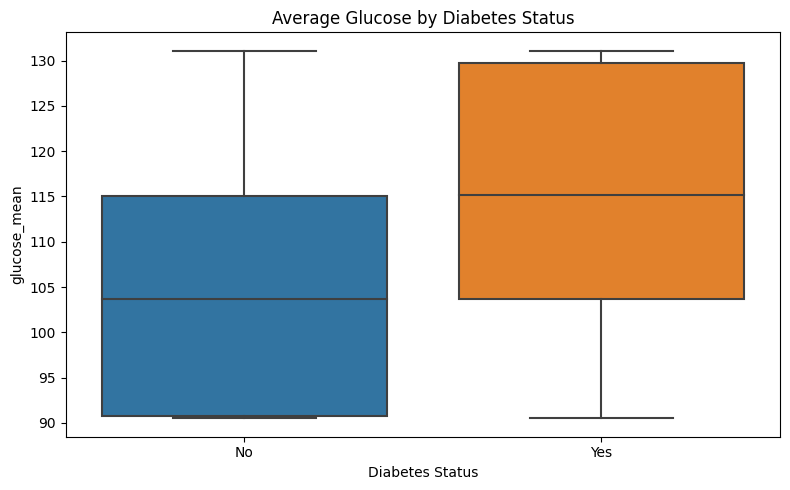

In [104]:
plot_feature_by_diabetes(synthetic_nhanes, 'glucose_mean', 'Average Glucose by Diabetes Status')

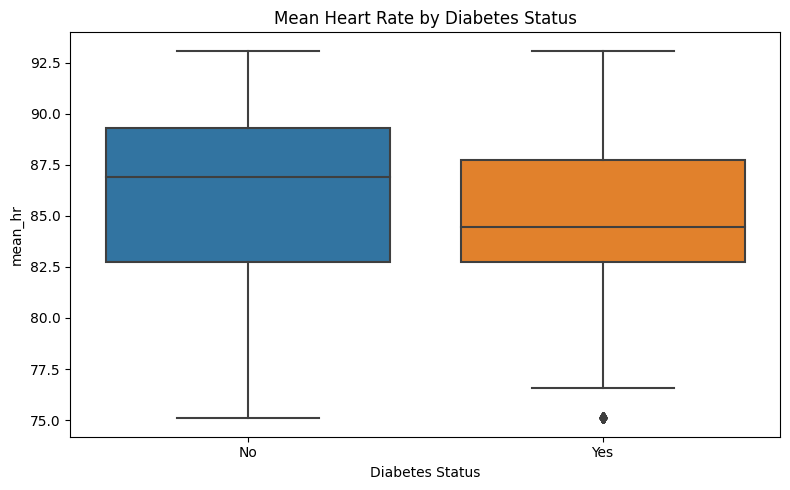

In [105]:
plot_feature_by_diabetes(synthetic_nhanes, 'mean_hr', 'Mean Heart Rate by Diabetes Status')

In [8]:
synthetic_nhanes.columns

Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1',
       'RIDRETH3', 'RIDEXMON', 'DMQMILIZ', 'DMDBORN4', 'DMDYRUSR', 'DMDEDUC2',
       'DMDMARTZ', 'DMDHHSIZ', 'WTINT2YR', 'WTMEC2YR', 'SDMVSTRA', 'SDMVPSU',
       'INDFMPIR', 'DIQ010', 'DIQ160', 'DIQ180', 'diabetes_status', 'index',
       'gyroscope_mean', 'gyroscope_std', 'gyroscope_min', 'gyroscope_max',
       'gyroscope_median', 'magnetic_field_mean', 'magnetic_field_std',
       'magnetic_field_min', 'magnetic_field_max', 'magnetic_field_median',
       'gravity_mean', 'gravity_std', 'gravity_min', 'gravity_max',
       'gravity_median', 'accelerometer_mean', 'accelerometer_std',
       'accelerometer_min', 'accelerometer_max', 'accelerometer_median',
       'accelerometer_percent_time_moving', 'avg_daily_steps', 'hr_zone_rest',
       'hr_zone_light', 'hr_zone_moderate', 'hr_zone_vigorous', 'hr_zone_max',
       'resting_hr', 'mean_hr', 'glucose_mean', 'glucose_iqr',
       'glucose_mean_roc', 'avg_weekl

### Now we try some predictive models

In [11]:
X = synthetic_nhanes.drop(columns=['diabetes_status'])
y = synthetic_nhanes['diabetes_status'].map({'No': 0, 'Yes': 1})

NameError: name 'synthetic_nhanes' is not defined

In [12]:
# initial run resulted in all perfect prediciton, so we need to clean the dataset of leakage
leak_cols = ['glucose_mean', 'glucose_score', 'glucose_weight',
    'DIQ050', 'DIQ070', 'DIQ160', 'DIQ180', 'DID040', 'SEQN', 'index']

X = X.drop(columns=[col for col in leak_cols if col in X.columns])

NameError: name 'X' is not defined

In [35]:
seed = 100

models = {
    'RandomForest (default)': RandomForestClassifier(random_state=seed),
    'RandomForest (max_depth=5)': RandomForestClassifier(max_depth=5, random_state=seed),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=seed),
    'HistGradientBoost': HistGradientBoostingClassifier(random_state=seed)
}

results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for name, model in models.items():
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': []
    }

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
    results.append({
        'Model': name,
        'Accuracy (Mean)': np.mean(metrics['accuracy']),
        'Precision (Mean)': np.mean(metrics['precision']),
        'Recall (Mean)': np.mean(metrics['recall']),
        'F1 Score (Mean)': np.mean(metrics['f1'])
    })
    
results_df = pd.DataFrame(results)

In [12]:
data_df = synthetic_nhanes.copy()
model_results_df = results_df.copy()

numeric_cols = data_df.select_dtypes(include='number').columns.tolist()


app_ui = ui.page_fluid(
    ui.h2("Health Data Dashboard"),
    ui.navset_tab(
        ui.nav_panel("Feature Comparison",
            ui.input_select("feature", "Select a feature:", choices=numeric_cols),
            ui.output_plot("feature_plot")
        ),
        ui.nav_panel("Model Performance",
            ui.output_plot("model_plot")
        )
    )
)

def server(input, output, session):
    @output
    @render.plot
    def feature_plot():
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=data_df, x='diabetes_status', y=input.feature())
        plt.title(f"{input.feature()} by Diabetes Status")
        plt.tight_layout()
        return plt.gcf()

    @output
    @render.plot
    def model_plot():
        plt.figure(figsize=(10, 5))
        melted = model_results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
        sns.barplot(data=melted, x='Model', y='Score', hue='Metric')
        plt.title("Model Performance Comparison")
        plt.xticks(rotation=15)
        plt.tight_layout()
        return plt.gcf()


app = App(app_ui, server)

In [159]:
run_app(app)

RuntimeError: asyncio.run() cannot be called from a running event loop